# Assignment 04


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import geopandas as gpd

In [2]:
datasets_dir = Path('../../../datasets')
# ls ../../

In [3]:
datasets_dir

WindowsPath('../../../datasets')

In [4]:
moscow_gdb_path = datasets_dir / 'moscow' / 'moscow_vectors' / 'Moscow.gdb'
print(moscow_gdb_path)
print(type(moscow_gdb_path))

..\..\..\datasets\moscow\moscow_vectors\Moscow.gdb
<class 'pathlib.WindowsPath'>


In [5]:
import fiona
moscow_gdb = str(moscow_gdb_path)

fiona.listlayers(moscow_gdb)

['Moscow_Zoning',
 'Centerlines',
 'Moscow_Parks',
 'Moscow_City_Limit',
 'Parcels']

In [6]:
parcels = gpd.read_file(moscow_gdb, layer='Parcels')
roads = gpd.read_file(moscow_gdb, layer='Centerlines')
zoning = gpd.read_file(moscow_gdb, layer='Moscow_Zoning')
city_limits = gpd.read_file(moscow_gdb, layer='Moscow_City_Limit')
parks = gpd.read_file(moscow_gdb, layer='Moscow_Parks')


In [7]:
parcels.columns

Index(['LABEL', 'PM_PAR_14', 'PM_MAIL_NM', 'PM_MAIL_A1', 'PM_MAIL_A2',
       'PM_MAIL_CT', 'PM_MAIL_ST', 'PM_MAIL_ZP', 'PM_PROP_AD', 'PM_DEEDCDT',
       'PM_DEEDRF1', 'PM_DEEDRF2', 'PM_DEEDRF3', 'PM_DEEDRF4', 'PM_DEEDRF5',
       'PM_TAX_AMT', 'PM_PV_AREA', 'PM_PV_NBHD', 'PM_PV_ACRE', 'PM_TOT_VAL',
       'PM_IMP_VAL', 'PM_LND_VAL', 'PM_EX_VAL', 'PM_NET_VAL', 'PM_CATS',
       'LG_LINE_1', 'LG_LINE_2', 'LG_LINE_3', 'LG_LINE_4', 'LG_LINE_5',
       'LG_LINE_6', 'PM_PARC_CD', 'GlobalID', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

### Shapely geometries
Behind the scenes, geopandas is reading in vector data, storing the attribute tables as `pandas` dataframes,
and storing the vector geometry as `shapely` geometries.


### Reading:
To become more familiar with vector operations in geopandas/shapely, 
read this introduction to shapely geometries carefully, 
and reproduce/experiment with the code in this reading from within a blank notebook:
https://towardsdatascience.com/geospatial-adventures-step-1-shapely-e911e4f86361

Read this page for a more comprehensive description of `shapely` geometries: 
https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html

Scroll through the `shapely` user manual (https://shapely.readthedocs.io/en/stable/manual.html), 
reviewing the different functions that shapely includes.  `geopandas` allows all of these functions to be
executed, [directly through `geopandas`, without explicit call to `shapely`](https://geopandas.org/docs/user_guide/geometric_manipulations.html).  `shapely` is just running
quietly under the hood.  Pay specific attention to the "Spatial Analysis Methods" of the manual.

In [8]:
from shapely.geometry import LineString
line = LineString([(0, 0), (1, 1), (2, 0)])
print('Line area =', line.area)
print('Line length =', line.length)

Line area = 0.0
Line length = 2.8284271247461903


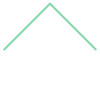

In [9]:
line

In [10]:
type(line)

shapely.geometry.linestring.LineString

In [11]:
print( list(line.coords) )
print( line.coords[2] )

[(0.0, 0.0), (1.0, 1.0), (2.0, 0.0)]
(2.0, 0.0)


<div class="alert alert-block alert-warning">

## 1. Shapely geometries
What `shapely` geometry are each of the parcels in the Moscow parcels layer? What `shapely` geometry are their centroids?
    
Find the Kenworthy Theater within the parcels database (hint: the name field for its mailing address, 
    PM_MAIL_NM, is "KENWORTHY PERFORMING ARTS CTR").
What are the coordinates for the corners of its parcel?    
</div>


In [12]:
import pandas as pd
parcel_geom = pd.unique([type(x) for x in parcels['geometry']])[0] # Check data type for all elements in the geometry column; Identify unique types
parcel_geom

shapely.geometry.multipolygon.MultiPolygon

In [13]:
centroids = pd.unique([type(x.centroid) for x in parcels['geometry']])[0] # Determine geometries of all parcel centroids
centroids

shapely.geometry.point.Point

In [14]:
ken_theater = parcels[parcels['PM_MAIL_NM']=='KENWORTHY PERFORMING ARTS CTR'] # Create new gdf of the Kenworthy Center
list(ken_theater['geometry'][1359][0].exterior.coords) # Determine the coordinates for all corners of the Kenworthy parcel

[(2311036.9459081627, 1848531.879651986),
 (2311036.277274329, 1848471.8833809048),
 (2310911.285070244, 1848473.2760946527),
 (2310911.9537040778, 1848533.2723657414),
 (2311036.9459081627, 1848531.879651986)]

FACILITYID                                               PR-E17-G
NAME                                                Ghormley Park
SUBTYPEFIELD                                                    0
FEATURECODE                                                      
FULLADDR                                              504 Home St
OPERDAYS                                                         
OPERHOURS                                                        
PARKAREA                                                     7.34
PARKURL         https://www.ci.moscow.id.us/parks-rec/parks/Pa...
NUMPARKING                                                    0.0
RESTROOM                                                      Yes
ADACOMPLY                                                        
CAMPING                                                        No
SWIMMING                                                       No
HIKING                                                         No
FISHING   

<AxesSubplot:>

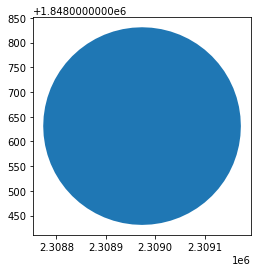

In [15]:
i = 2 # Look at one park, for example
print(parks.iloc[i])

buffer_radius = 200 # What are the units for this?

buffered_park = parks.iloc[i:i+1].buffer(buffer_radius) # Careful!  I'm not sure why this is, but geopandas requires a slice here, not a single index
    #If you use just one index, it seems to remove all the geopandas properties of the data
buffered_park.plot()



<div class="alert alert-block alert-warning">

## 2. Identifying Moscow residents underserved by city parks.
You're an urban planner consulting with the City of Moscow.  The city is interested in increasing the number of parks
    within the city, and better designing those parks to meet the needs of those who are currently underserved
    by the city's existing parks.  The city wants to begin the planning process by reaching out to these currently
    underserved residents, but first the city needs to know who they are.
    
The city asks you to produce a list of all resident addresses within the city limits whose property is at least 1000 feet
    from a current park.
    
To properly address the letters and questionaires that the city will be sending out, the city would like this list
    of residents as a csv file, with each property address on a separate line (property addresses are represented within
    the parcels database by the field name "PM_PROP_AD").  Produce this file and a map of the underserved parcels.
    


</div>


In [16]:
parcel_centroids = parcels['geometry'].centroid # Create Geoseries of parcel centroids
citylim_centroids = gpd.clip(parcel_centroids,city_limits) # Clip all parcel centroids located in the city limits

all_park_dists = [] # List for storing parcel centroid distances to all Moscow parks

for i in citylim_centroids.index: # Need to keep and iterate through original indicies of parcels gdf
    for x in range(len(parks['geometry'])): # Iterate through all Moscow parks
        all_distances = citylim_centroids[i].distance(parks['geometry'][x]) # Calculate distance between each parcel centroid and all Moscow parks
        all_park_dists.append(all_distances) # Append all distances to all_park_dists list
                                                      
parcel_dist_to_park = [all_park_dists[x:x+len(parks['geometry'])] for x in range(0,len(all_park_dists),len(parks['geometry']))]             
# Create nested listed of park distances for each parcel centroid

parceldist_df = pd.DataFrame({'Dists to Parks' : parcel_dist_to_park},index=citylim_centroids.index) #Create new Pandas df, matching park distance lists to original index

within_1000 = [] # List for storing boolean results from if statement below

for i in parceldist_df.index: # Iterate through original indicies
    if min(parceldist_df['Dists to Parks'][i]) >= 1000: # If the min value in a park distance list is greater than 1000, append no to within_1000 list for that iteration
        within_1000.append('No')
    elif min(parceldist_df['Dists to Parks'][i]) <= 1000: # If the min value in a park distance list is less than 1000, append yes to within_1000 list for that iteration
        within_1000.append('Yes')

parceldist_df['Within 1000 feet'] = within_1000 # Create new column in parceldist_df with boolean results from if statement
orig_indicies = parceldist_df.index[parceldist_df['Within 1000 feet'] == 'No'].tolist() # Create a list of original indicies that are not within 1000 feet of a park
addresses = parcels.iloc[orig_indicies]['PM_PROP_AD'] # Index parcels gdf with the original indicies and return a Series of corresponding addresses
addresses.to_csv('resident_addresses.csv') # Write the addresses to a CSV format
pd.read_csv('resident_addresses.csv') # Read resident_addresses CSV; some parcels don't have addresses


,Unnamed: 0,PM_PROP_AD
0,3,328 N MAIN
1,4,340 N MAIN
2,9,227 N JEFFERSON
3,10,203 N JEFFERSON
4,12,
...,...,...
2874,7387,
2875,7389,
2876,7390,
2877,7391,


In [17]:
park_buffers = gpd.GeoDataFrame(gpd.clip(parks,city_limits).buffer(1000),columns=['geometry']) # Clip all parks in Moscow city limits and apply a 1000 ft buffer to all
city_parcels = gpd.overlay(city_limits,parcels, how='intersection') # Return the intersections between the city_limits and parcels gdfs
res_addresses = gpd.overlay(city_parcels,park_buffers, how='symmetric_difference')['PM_PROP_AD'] 
# Determine the symmetric difference between city_parcels and park_buffers, then call the remaining addresses

In [18]:
%matplotlib widget
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

gpd.clip(parks,city_limits).plot(ax=ax1,color='red',label='Parks') # Plot park locations within Moscow city limits
parcels.iloc[orig_indicies].plot(ax=ax1,color='blue',label='Parcels') # Plot underserved parcels; label not generating in legend?
ax1.set_title("Parcels Underserved by Moscow Parks\n(My Initial Method)",weight='bold')
ax1.set_xlabel('Easting (ft)')
ax1.set_ylabel('Northing (ft)')
ax1.legend()

gpd.overlay(city_parcels,park_buffers, how='symmetric_difference').plot(ax=ax2,color='blue',label='Parcels') # Overlay Method (discovered after my intial method)
gpd.clip(parks,city_limits).plot(ax=ax2,color='red',label='Parks')
ax2.set_title("Parcels Underserved by Moscow Parks\n(Overlay Method)",weight='bold')
ax2.set_xlabel('Easting (ft)')
ax2.set_ylabel('Northing (ft)')
ax2.legend()

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
%matplotlib widget

fig, ax = plt.subplots()
parks.buffer(buffer_radius).plot(ax=ax, color='g')
# city_limits.plot(ax=ax, color=None, edgecolor='r')
roads.plot(ax=ax)

ax.set_xlim( city_limits.bounds.to_numpy()[0][::2] )
ax.set_ylim( city_limits.bounds.to_numpy()[0][1::2] )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1837691.7277759165, 1858582.946164012)

In [20]:
roads

,CENTERLINEID,FROMLEFT,TOLEFT,FROMRIGHT,TORIGHT,FULLNAME,FEDROUTE,FEDRTETYPE,AFEDRTE,AFEDRTETYPE,...,SLOPE,OCI2017,OCI2014,GlobalID,FACILITYID,OCI2019,OCI2020,ADTID,SHAPE_Length,geometry
0,02600,0.0,0.0,0.0,0.0,MAIN ST,None,Other,None,None,...,NaN,58.92,71.66,{E10997BF-346F-493B-9078-ABF3BA07D894},STREET-02600,96.08,96.08,F19-05,87.664841,"MULTILINESTRING ((2310851.729 1847250.622, 231..."
1,01430,0.0,0.0,0.0,0.0,FIRST ST,None,Other,None,None,...,NaN,90.93,98.96,{F2D06156-E244-4542-A0A7-9F47285F09AF},STREET-01430,86.04,86.04,G16-05,349.983212,"MULTILINESTRING ((2310883.550 1849572.726, 231..."
2,02670,102.0,114.0,105.0,205.0,MAIN ST,None,Other,None,None,...,NaN,71.70,100.00,{BF94EEC2-9DBF-42FD-8BA0-31C170DEC8CB},STREET-02670,80.02,80.02,F17-12,230.721479,"MULTILINESTRING ((2310883.464 1849564.375, 231..."
3,02660,204.0,218.0,205.0,221.0,MAIN ST,None,Other,None,None,...,NaN,71.70,100.00,{E4ADA45C-08D8-4C70-B30F-46E1097647A3},STREET-02660,80.02,80.02,F17-06,239.999980,"MULTILINESTRING ((2310880.869 1849333.668, 231..."
4,02650,302.0,318.0,301.0,307.0,MAIN ST,None,Other,None,None,...,NaN,91.97,100.00,{D3CE1840-EC8C-4124-AAEF-4A67AB2B5415},STREET-02650,95.17,95.17,F17-07,240.667684,"MULTILINESTRING ((2310878.196 1849093.683, 231..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,00301,1600.0,1756.0,1601.0,1751.0,THIRD ST,None,Other,None,None,...,5.0,NaN,NaN,{CE44A217-E6DA-4168-A8A9-C28AD394A399},STREET-00301,NaN,NaN,None,756.596825,"MULTILINESTRING ((2316177.219 1849043.781, 231..."
2214,13760,NaN,NaN,NaN,NaN,SOUTHVIEW AVE,None,None,None,None,...,10.0,NaN,NaN,{588D3E9B-7CBE-48D5-94BF-0DB57D0E0442},STREET-13760,NaN,NaN,None,706.800143,"MULTILINESTRING ((2312049.540 1843770.847, 231..."
2215,13765,NaN,NaN,NaN,NaN,SUNNY CT,None,None,None,None,...,7.0,NaN,NaN,{2F896E18-E40F-4BD6-81D2-5DDD91482100},STREET-13765,NaN,NaN,None,173.316937,"MULTILINESTRING ((2312699.813 1843557.137, 231..."
2216,13770,NaN,NaN,NaN,NaN,SOUTHVIEW AVE,None,None,None,None,...,10.0,NaN,NaN,{4BAB6FC8-B24E-49A0-B852-9AF25FD43BF2},STREET-13770,NaN,NaN,None,221.456644,"MULTILINESTRING ((2312699.813 1843557.137, 231..."


In [21]:
zoning.columns

Index(['LANDUSECODE', 'LANDUSEDESC', 'BASEELEV', 'HEIGHT', 'LASTUPDATE',
       'LASTEDITOR', 'SUBTYPECODE', 'SUBTYPEDESC', 'PARCELID', 'ADDRESS',
       'LOCDESC', 'GlobalID', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [22]:
zoning['LANDUSEDESC'].unique()

array(['Auto-Urban Residential', 'University',
       'Parks, Recreation, and Open Space',
       'Auto-Urban Residential, Medium Density', 'Urban Commercial',
       'Urban Residential, Medium Density', 'Urban Residential',
       'Suburban Residential', 'Public and Semi-Public',
       'Auto-Urban Commercial', 'Vacant', 'Auto-Urban Industrial',
       'Agricultural', 'Research/Technology Park', '',
       'Suburban Commercial'], dtype=object)

In [23]:
zoning['LANDUSECODE'].unique()

array(['111', '750', '800', '109', '250', '115', '110', '120', '700',
       '200', '11', '400', '900', '999', '0', '150', None], dtype=object)

In [24]:
# We can measure the distance between any parcel and a point near the center of downtown Moscow
from shapely.geometry import Point
parcels['Dwntn_dist'] = parcels.distance(Point(2.311e6, 1.849e6))

#### Visualizing the data
I think each of the plots below is interesting.  Try commenting and uncommenting each one

In [25]:
%matplotlib widget
fig, ax = plt.subplots( figsize=(8,8) )

# These are a few of the interesting plots to look at.
#parcels.plot(column='Dwntn_dist', ax=ax, legend=True, vmax=5280);
zoning.plot(column='LANDUSEDESC', ax=ax, legend=True, cmap='tab20')
#parcels.plot(column= 'SaleYear', ax=ax, legend=True, vmin=1990)

ax.set_xlim( city_limits.bounds.to_numpy()[0][::2] )
ax.set_ylim( city_limits.bounds.to_numpy()[0][1::2] )

roads.plot(ax=ax, color='gray')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

### Property sales over time
Similar to the assignment from last week, we can look at the property sales as a function of time.

In [26]:
import pandas as pd
print( parcels['PM_DEEDCDT'].astype(str)[:4] )

parcels['SaleDate'] = pd.to_datetime(
    parcels['PM_DEEDCDT'], 
    errors='coerce', 
    format='%Y%m%d')


0    20120925.0
1    20120925.0
2           0.0
3    20190815.0
Name: PM_DEEDCDT, dtype: object


In [27]:
parcels['SaleDate']

0      2012-09-25
1      2012-09-25
2             NaT
3      2019-08-15
4      2019-08-15
          ...    
7389          NaT
7390          NaT
7391          NaT
7392          NaT
7393          NaT
Name: SaleDate, Length: 7394, dtype: datetime64[ns]

In [28]:
dates = parcels['PM_DEEDCDT'].to_numpy() # Pull out all the sale dates (initially floats)
yr = np.full( dates.shape, np.nan ) # initialize a variable full of nans

for i in range(len(dates)): 
    if dates[i] > 0:
        yr[i] = int( str(dates[i])[:4] )
    else:
        yr[i] = np.nan

parcels['SaleYear'] = yr # Create a new column for the parcels data frame representing sale year


In [29]:
bin_size = np.timedelta64(365, 'D')/12 # days
fig, ax = plt.subplots()
ax.hist(parcels['SaleDate'], bins=np.arange(np.datetime64('1990-01-01'), 
                                            np.datetime64('2022-01-01'), 
                                            bin_size ) )
ylabel_text = 'Number of property sales in Moscow\nper ' + str(bin_size.astype(int)) + ' days'
ax.set_ylabel(ylabel_text)
ax.set_xlim(np.datetime64('2000-01-01'), np.datetime64('2022-01-01') );
# ax.set_xlim(np.datetime64('2010-12-15'), np.datetime64('2011-01-01') )

# Note that the sales at the end of 2010 are anomalous, and are all recorded on the same day.
# That's suspicious and Tim thinks that it must be some change in accounting or record keeping.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<div class="alert alert-block alert-warning">

## 3. Investing in downtown property
You are the GIS consultant for a property investment company that specializes in
downtown and higher-density properties.  Your company is considering Moscow real estate.
You've heard about the boom in sales within the city, and your company would like to know how competitive
property purchasing will be, or if they will be able to drive a hard bargin.

Has the downtown property market heated up as much as within the city as a whole?
Compare sale rates within two of the zoned downtown regions with those of the city as a whole.
    
Is there anything else in these data that you would like to share with your colleagues
    that could help advise them as you consider this investment?
</div>

In [30]:
urb_res = zoning[zoning['LANDUSEDESC']=='Urban Residential, Medium Density'] # Create new gdfs for zoned downtown regions
auto_urb_res = zoning[zoning['LANDUSEDESC']=='Auto-Urban Residential, Medium Density']

urb_res_parcels = gpd.overlay(parcels,urb_res, how='intersection') # Create new gdfs of zone intersections with parcels to access SaleDate
auto_urb_res_parcels = gpd.overlay(parcels,auto_urb_res, how='intersection')

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(11.5,5))

# Plot 3 histograms of property sales over time; one for Moscow; one for each of the zoned downtown regions
ax1.hist(parcels['SaleDate'], bins=np.arange(np.datetime64('1990-01-01'), np.datetime64('2022-01-01'),bin_size))
ax1.set_title('In Moscow')

ax2.hist(urb_res_parcels['SaleDate'], bins=np.arange(np.datetime64('1990-01-01'), np.datetime64('2022-01-01'), bin_size))
ax2.set_title('In Urban Residential,\nMedium Density Zone')

ax3.hist(auto_urb_res_parcels['SaleDate'], bins=np.arange(np.datetime64('1990-01-01'), np.datetime64('2022-01-01'), bin_size))
ax3.set_title('In Auto-Urban Residential,\nMedium Density Zone')

for ax in (ax1,ax2,ax3): # Loop through axes objects for iterable plot formatting
    ax.set_ylabel('Number of property sales per ' + str(bin_size.astype(int)) + ' days')
    ax.set_xlim(np.datetime64('2000-01-01'), np.datetime64('2022-01-01'))
    ax.set_xlabel('Year')
    
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<div class="alert alert-block alert-warning">

## 4. Find, plot, work with data of your own
Find a spatial, vector dataset of your choosing (by googling, from another class, 
    or from a research project of yours). This could be climate data, geologic units,
    census data, ecological units, demographic data, etc. Download or copy this dataset
    into the current directory, plot it, and use geopandas to draw on the attributes 
    of that data (even just lengths, areas, etc) and tell me something about that data.
</div>

In [ ]:
states = gpd.read_file('cb_2018_us_state_500k.geojson') # Census gdf of US
idaho = states[states['NAME']=='Idaho'] # Create new gdf of just Idaho
idaho_proj = idaho.to_crs(epsg=parcels.crs.to_epsg()) # Project idaho gdf to the parcels gdf EPSG

ws_watersheds = gpd.read_file('Wild_and_Scenic_Watersheds.geojson') # Load IDWR Wild and Scenic Watersheds GeoJSON
ws_watersheds['Centroid'] = ws_watersheds['geometry'].centroid # Create centroid column for annotations later on
ws_watersheds

In [32]:
ws_watersheds.crs # Data came in a geographic coordinate system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
proj_watersheds = ws_watersheds.to_crs(epsg=parcels.crs.to_epsg()) # Project watersheds dataset to the parcels gdf EPSG
proj_watersheds['Shape_Area_mi2'] = proj_watersheds['Shape_Area']/27878400 # Add an area column in mi2 for better readability
proj_watersheds

,FID,NAME,Shape_Leng,Shape_Area,DisName,AreaID,geometry,Centroid,Shape_Area_mi2
0,0,Battle Creek,2.135606e+05,6.824519e+08,Battle Creek,60,"POLYGON ((2456475.772 393266.845, 2456404.534 ...",POINT (-116.38725 42.46551),24.479593
1,1,Big Jacks Creek,1.648467e+05,3.606025e+08,Big Jacks Creek,61,"POLYGON ((2552562.044 393876.664, 2552528.976 ...",POINT (-116.09647 42.55649),12.934835
2,2,Bruneau River,3.257480e+05,2.399888e+09,Bruneau River,62,"POLYGON ((2635806.786 398475.871, 2635752.985 ...",POINT (-115.42582 42.37295),86.084144
3,3,Cottonwood Creek,3.152853e+04,2.930482e+07,Cottonwood Creek,63,"POLYGON ((2536993.925 321320.366, 2536847.264 ...",POINT (-116.10561 42.48768),1.051166
4,4,Deep Creek,2.176621e+05,9.673446e+08,Deep Creek,64,"POLYGON ((2361355.636 379151.298, 2361325.982 ...",POINT (-116.65727 42.50236),34.698713
5,5,Dickshooter Creek,6.649627e+04,1.973720e+08,Dickshooter Creek,65,"POLYGON ((2435267.569 294863.732, 2435022.778 ...",POINT (-116.50100 42.39985),7.079748
6,6,Duncan Creek,5.752395e+04,6.889608e+07,Duncan Creek,66,"POLYGON ((2553224.689 327073.393, 2553176.268 ...",POINT (-116.05615 42.47882),2.471307
7,7,Jarbidge River,1.410966e+05,6.972195e+08,Jarbidge River,67,"POLYGON ((2652288.845 241654.502, 2652149.339 ...",POINT (-115.48184 42.12045),25.009308
8,8,Little Jacks Creek,7.608313e+04,1.876183e+08,Little Jacks Creek,68,"POLYGON ((2523039.446 375026.946, 2522903.732 ...",POINT (-116.20286 42.63177),6.729881
9,9,Lochsa R,4.218119e+05,3.058236e+09,Lochsa River,48,"POLYGON ((2888677.370 1851342.943, 2888544.823...",POINT (-114.96165 46.41163),109.699135


In [34]:
print(proj_watersheds.area) # Area in ft2
print(proj_watersheds.length) # Length in ft

0     7.344259e+09
1     3.881317e+09
2     2.584103e+10
3     3.154180e+08
4     1.040853e+10
5     2.123890e+09
6     7.415739e+08
7     7.507107e+09
8     2.019296e+09
9     3.293906e+10
10    6.002833e+09
11    8.021231e+10
12    2.935686e+09
13    2.377345e+10
14    3.013112e+09
15    1.437471e+09
16    2.579254e+11
17    5.605820e+10
18    1.481291e+10
19    9.339167e+09
20    1.315790e+10
21    3.004244e+09
22    1.626419e+09
dtype: float64
0     7.005828e+05
1     5.408249e+05
2     1.068902e+06
3     1.034375e+05
4     7.139798e+05
5     2.181324e+05
6     1.887248e+05
7     4.629836e+05
8     2.496036e+05
9     1.384325e+06
10    3.896415e+05
11    1.784229e+06
12    3.742144e+05
13    1.285084e+06
14    2.807858e+05
15    2.083272e+05
16    5.272971e+06
17    1.700591e+06
18    7.017233e+05
19    5.027829e+05
20    6.428403e+05
21    3.985865e+05
22    2.349670e+05
dtype: float64


In [35]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,5))

ws_watersheds.plot(ax=ax1) # Plot watersheds in the original geographic coordinate system
idaho['geometry'].exterior.plot(ax=ax1,color='black',lw=.5) # Plot outline of Idaho (GCS)

ax1.set_title("Idaho's Wild\nand Scenic Watersheds",weight='bold')
ax1.set_xlabel('Longitude (\u00b0E)')
ax1.set_ylabel('Latitude (\u00b0W)')

for i, label in enumerate(ws_watersheds['NAME']): # Create annotations for each watershed; it's messy, not sure how to fix this
    ax1.annotate(label,(ws_watersheds['Centroid'][i].x,ws_watersheds['Centroid'][i].y),size=5)

proj_watersheds.plot(ax=ax2,column='Shape_Area_mi2',cmap='autumn_r',legend=True,legend_kwds={'label': "Watershed Area (mi\u00b2)"},vmin=0,vmax=900)
# Plot the areas of the projected watersheds
idaho_proj['geometry'].exterior.plot(ax=ax2,color='black',lw=.5) # Plot outline of Idaho (Projected)

ax2.set_title("Area of Idaho's\nWild and Scenic Watersheds",weight='bold',pad=12)
ax2.set_xlabel('Easting (ft)')
ax2.set_ylabel('Northing (ft)')

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …